In [1]:
# Clear workspace
%reset

# standard packages
from math import e
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle as pkl
import os
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score, precision_recall_curve, plot_precision_recall_curve
from scipy.stats import sem
pd.options.display.max_colwidth = 100

# SGL packages
from group_lasso import LogisticGroupLasso
LogisticGroupLasso.LOG_LOSSES = True

%reload_ext autoreload
%autoreload 2

working_dir = "~/Desktop/hif2gene"


Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
seed = 360
np.random.seed(seed)

## Load in HIFs + Clusters 

In [3]:
# Load in HIF dataset with labels
# NAs removed, already converted to patient-level
df = pd.read_csv("{0}/data/genetic_data/TIGIT/datasets/stad.TIGIT.joined.USE.csv".format(working_dir))
df = df.iloc[:,1:]
df

,AREA..MM2..OF..EPITHELIAL..IN..TISSUE._HE,AREA..MM2..OF..ESI_0080..IN..TISSUE._HE,AREA..MM2..OF..NECROSIS..IN..TISSUE._HE,AREA..MM2..OF..STROMA..IN..TISSUE._HE,AREA..MM2..OF..TUMOR..IN..TISSUE._HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.EPITHELIAL_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.ESI_0080_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.STROMA_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.TUMOR_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.FIBROBLAST.IN.EPITHELIAL_HE,...,DENSITY..LYMPHOCYTE.CELLS..IN..TUMOR._HE,DENSITY..MACROPHAGE.CELLS..IN..EPITHELIAL._HE,DENSITY..MACROPHAGE.CELLS..IN..ESI_0080._HE,DENSITY..MACROPHAGE.CELLS..IN..STROMA._HE,DENSITY..MACROPHAGE.CELLS..IN..TUMOR._HE,DENSITY..PLASMA.CELLS..IN..EPITHELIAL._HE,DENSITY..PLASMA.CELLS..IN..ESI_0080._HE,DENSITY..PLASMA.CELLS..IN..STROMA._HE,DENSITY..PLASMA.CELLS..IN..TUMOR._HE,joined.TIGIT_label
0,59.590176,84.306652,7.306912,53.993840,113.584016,6759.753519,7221.951811,6485.585474,6865.555331,5769.557121,...,1357.435715,126.598049,192.950374,350.743714,233.149002,52.307280,109.552447,234.230423,138.787134,0
1,67.366416,75.518360,0.439232,57.311648,124.678064,7014.109958,6720.216572,5946.464815,7133.129038,6060.862361,...,1013.738872,99.218578,155.458884,160.770111,127.512407,87.833083,132.206261,124.843732,104.846030,1
2,5.130728,2.535068,1.969952,7.274280,12.405008,4188.040446,4497.799597,3092.672748,4261.210073,1819.766719,...,3362.996622,233.495130,262.714846,230.538280,231.761237,814.894105,1668.199827,1269.678924,1081.579311,1
3,88.432176,96.889988,5.167376,51.436512,139.868688,7214.894003,6884.054606,6177.335784,7254.064662,5684.018407,...,895.875995,44.814005,119.878227,354.728563,158.784645,11.149788,110.702873,287.344523,112.720011,1
4,41.619616,65.315464,0.533040,77.525136,119.144752,6443.873910,6207.110101,6230.700870,6868.847974,5226.830998,...,1514.854805,378.547462,444.198023,596.477509,520.350237,88.852333,140.456784,176.652383,145.982091,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,6.169648,5.983748,0.032288,3.186688,9.356336,6977.868074,7027.761762,6588.275362,7169.328309,5145.402758,...,372.795505,48.625140,59.661603,111.087122,69.899157,3.890011,11.698354,39.853290,16.138796,0
250,1.051312,1.478308,0.024544,4.219840,5.271152,4962.390265,4399.053774,3791.255401,3993.354719,3033.801117,...,1888.391760,12.365501,12.852531,19.195041,17.832914,65.632277,41.939839,32.465686,39.080641,1
251,5.971184,9.709772,0.078176,6.659696,12.630880,6536.185121,6234.149001,5818.373510,6534.833377,3262.361890,...,1701.464981,41.700273,92.278171,190.098767,119.944137,33.159253,101.753162,156.163284,98.013757,1
252,24.957536,49.108412,0.967808,33.495056,58.452592,6729.529134,6894.401077,6049.724804,6699.648603,6379.729017,...,1163.353030,65.551343,67.809157,77.474120,72.383445,54.692899,68.644044,85.146895,72.143935,1


In [4]:
# Normalize HIFs and define X, y
X = df.iloc[:,:607]
X_normalized = (X-X.mean())/X.std()
X_normalized

,AREA..MM2..OF..EPITHELIAL..IN..TISSUE._HE,AREA..MM2..OF..ESI_0080..IN..TISSUE._HE,AREA..MM2..OF..NECROSIS..IN..TISSUE._HE,AREA..MM2..OF..STROMA..IN..TISSUE._HE,AREA..MM2..OF..TUMOR..IN..TISSUE._HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.EPITHELIAL_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.ESI_0080_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.STROMA_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.TUMOR_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.FIBROBLAST.IN.EPITHELIAL_HE,...,DENSITY..LYMPHOCYTE.CELLS..IN..STROMA._HE,DENSITY..LYMPHOCYTE.CELLS..IN..TUMOR._HE,DENSITY..MACROPHAGE.CELLS..IN..EPITHELIAL._HE,DENSITY..MACROPHAGE.CELLS..IN..ESI_0080._HE,DENSITY..MACROPHAGE.CELLS..IN..STROMA._HE,DENSITY..MACROPHAGE.CELLS..IN..TUMOR._HE,DENSITY..PLASMA.CELLS..IN..EPITHELIAL._HE,DENSITY..PLASMA.CELLS..IN..ESI_0080._HE,DENSITY..PLASMA.CELLS..IN..STROMA._HE,DENSITY..PLASMA.CELLS..IN..TUMOR._HE
0,0.239706,0.367968,0.106788,-0.104593,0.058221,0.378370,1.348262,1.052511,0.371016,0.539893,...,0.316742,0.404348,0.440072,0.582761,0.490892,0.686182,-0.031889,-0.073602,0.003980,0.059381
1,0.452658,0.188748,-0.586752,-0.031583,0.219688,0.676024,0.654167,0.355250,0.716929,0.839645,...,-0.511642,-0.075527,0.111784,0.222531,-0.425519,-0.264154,0.396680,0.062276,-0.397630,-0.167684
2,-1.251658,-1.299605,-0.432170,-1.132682,-1.414385,-2.631109,-2.420299,-3.335648,-2.995818,-3.524421,...,2.325069,3.204540,1.721803,1.253078,-0.088965,0.673697,9.167645,9.275232,3.805601,6.366634
3,1.029541,0.624581,-0.109275,-0.160869,0.440780,0.910986,0.880819,0.653842,0.873271,0.451874,...,0.308568,-0.240088,-0.540545,-0.119338,0.510115,0.017180,-0.528396,-0.066702,0.198987,-0.115007
4,-0.252415,-0.019320,-0.577278,0.413225,0.139154,0.008720,-0.055659,0.722861,0.375273,-0.018569,...,0.230537,0.624139,3.461027,2.996823,1.676285,3.269924,0.408976,0.111763,-0.207416,0.107515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,-1.223208,-1.229276,-0.627847,-1.222632,-1.458757,0.633612,1.079622,1.185323,0.763726,-0.102359,...,-0.844464,-0.970421,-0.494848,-0.697917,-0.665184,-0.782459,-0.615975,-0.660535,-0.709670,-0.761133
250,-1.363373,-1.321155,-0.628629,-1.199897,-1.518214,-1.724947,-2.556903,-2.432149,-3.342095,-2.275186,...,0.235112,1.145676,-0.929613,-1.147673,-1.108462,-1.250861,0.128858,-0.479145,-0.736793,-0.607652
251,-1.228643,-1.153291,-0.623213,-1.146206,-1.411097,0.116745,-0.018253,0.189585,-0.056533,-2.039998,...,1.278298,0.884686,-0.577879,-0.384528,-0.284041,-0.332240,-0.262883,-0.120383,-0.282641,-0.213392
252,-0.708704,-0.349832,-0.533373,-0.555680,-0.744187,0.343000,0.895132,0.488799,0.156536,1.167757,...,-0.181188,0.133367,-0.291897,-0.619633,-0.827330,-0.760109,-0.003110,-0.318972,-0.543376,-0.386460


In [5]:
y = df.iloc[:,607]
print(np.sum(y))

170


In [6]:
# Load in clusters
clusters = pd.read_csv("{0}/data/hif_clusters/STAD.hif.clusters.csv".format(working_dir))
print("Number of Clusters: {0}".format(len(set(clusters['x']))))
clusters


Number of Clusters: 23


,Unnamed: 0,x
0,AREA (MM2) OF [EPITHELIAL] IN [TISSUE]_HE,1
1,AREA (MM2) OF [ESI_0080] IN [TISSUE]_HE,1
2,AREA (MM2) OF [NECROSIS] IN [TISSUE]_HE,2
3,AREA (MM2) OF [STROMA] IN [TISSUE]_HE,3
4,AREA (MM2) OF [TUMOR] IN [TISSUE]_HE,1
...,...,...
602,TOTAL [MACROPHAGE CELLS] IN [TUMOR]_HE,1
603,TOTAL [PLASMA CELLS] IN [EPITHELIAL]_HE,1
604,TOTAL [PLASMA CELLS] IN [ESI_0080]_HE,1
605,TOTAL [PLASMA CELLS] IN [STROMA]_HE,1


## Define Nested CV Parameters

In [7]:
num_outer_loops = 3 # for estimating generalization error
num_inner_loops = 5 # for hyper-parameter tuning
training_aurocs = [0.0, 0.0, 0.0]
generalization_aurocs = [0.0, 0.0, 0.0]
training_auprcs = [0.0, 0.0, 0.0]
generalization_auprcs = [0.0, 0.0, 0.0]

# Define outer loops (A, B, and C)
X_train_AB, X_train_C, y_train_AB, y_train_C = train_test_split(X_normalized, y, test_size=1/3, random_state=seed, stratify=y)
X_train_A, X_train_B, y_train_A, y_train_B = train_test_split(X_train_AB, y_train_AB, test_size=1/2, random_state=seed, stratify=y_train_AB)

# Verify correctness
print(len(X_train_A), len(y_train_A))
print(len(X_train_B), len(y_train_B))
print(len(X_train_C), len(y_train_C))

print(np.sum(y_train_A)/len(y_train_A))
print(np.sum(y_train_B)/len(y_train_B))
print(np.sum(y_train_C)/len(y_train_C))

84 84
85 85
85 85
0.6666666666666666
0.6705882352941176
0.6705882352941176


### Outer Loop 1

In [8]:
# Define outer loop train and test
X_train_1 = np.array(X_train_A.append(X_train_B))
y_train_1 = np.array(y_train_A.append(y_train_B))
print(X_train_1.shape, y_train_1.shape)

X_test_1 = np.array(X_train_C)
y_test_1 = np.array(y_train_C)
print(X_test_1.shape, y_test_1.shape)

(169, 607) (169,)
(85, 607) (85,)


In [9]:
# Define k-folds object
skf = StratifiedKFold(n_splits=num_inner_loops)
skf.get_n_splits(X_train_1, y_train_1)

5

In [ ]:
# K-folds: hyper-parameter tuning
num_regs = 30
regs = list(np.logspace(-7, -2, num_regs, base=e))
print(regs)

cv_aucs = [] # based on k-folds CV

for reg in regs:
    print(reg)
    k_folds_count = 1
    
    aucs = [] 
    for train_index, test_index in skf.split(X_train_1, y_train_1):
        print(k_folds_count)

        # Define train / test
        X_train, X_test = X_train_1[train_index], X_train_1[test_index]
        y_train, y_test = y_train_1[train_index], y_train_1[test_index]
        print(np.sum(y_train)/len(y_train), np.sum(y_test)/len(y_test))
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
        
        # SGL 
        sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=reg*(1/6), l1_reg=reg*(5/6), n_iter=1000, 
                                 tol=1e-6, old_regularisation=False, warm_start=True, random_state=seed)
        sgl.fit(X_train, y_train)

        # Compute AUC on test set
        y_probs_test = sgl.predict_proba(X_test)[1] # predicted probability y = 1
        fpr, tpr, thresholds = roc_curve(y_test, y_probs_test, pos_label=1)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        k_folds_count += 1
    
    print(aucs)
    cv_aucs.append(np.mean(np.array(aucs)))

[0.7334141813390825, 0.7342406276200742, 0.7349652653012336, 0.7334171757096659, 0.7303569289735297, 0.7303239908971134, 0.7225146724158582, 0.7217600910288657, 0.7193136902623068, 0.7161785842615883, 0.711468439334052, 0.7019403521379806, 0.6974278356689424, 0.7118427356569649, 0.7031111510360523, 0.6729638280033537, 0.6864744280752186, 0.7066774464007665, 0.7108486046233082, 0.7150856389986826, 0.7048059647862019, 0.718565097616481, 0.7261977482333213, 0.7614235237753024, 0.7558869325667745, 0.751074979039406, 0.6875404240028746, 0.5, 0.5, 0.5]


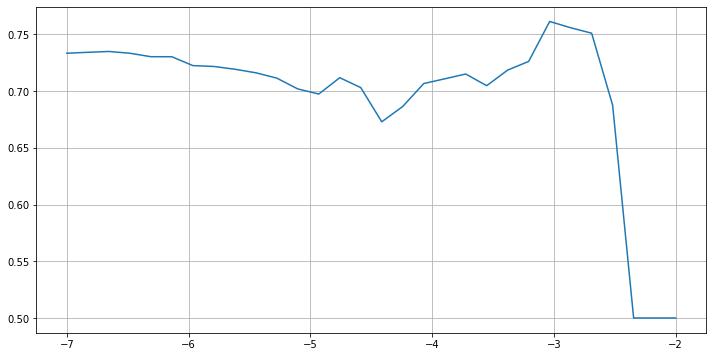

0.048099535512554845 -3.0344827586206895


In [12]:
# Plot CV AUCs
print(cv_aucs)
plt.figure(figsize=(12,6))
plt.plot(np.log(regs), cv_aucs)
plt.grid(axis='both')
plt.show()

max_reg = regs[np.argmax(np.array(cv_aucs))]
print(max_reg, np.log(max_reg))

In [ ]:
# Choose best regularization parameter based on CV plot
optimal_log_reg = -3.6
optimal_reg = np.exp(optimal_log_reg)
print(optimal_log_reg, optimal_reg)

# Fit "optimal model"
optimal_sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=optimal_reg*(1/6), l1_reg=optimal_reg*(5/6), n_iter=1000, 
                         tol=1e-6, old_regularisation=False, warm_start=False, random_state=seed)
optimal_sgl.fit(X_train_1, y_train_1)

# Store optimal model
optimal_sgl_1 = optimal_sgl

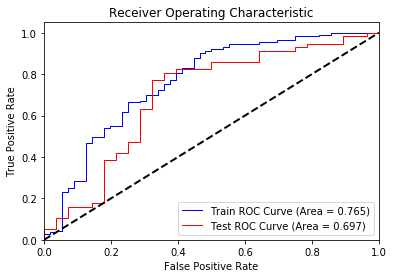

In [10]:
# Plot Train and Test ROCs
y_pred_probs_train = optimal_sgl.predict_proba(X_train_1)[1] # predicted probability y = 1
y_pred_probs_test = optimal_sgl.predict_proba(X_test_1)[1]

# Train
fpr, tpr, thresholds = roc_curve(y_train_1, y_pred_probs_train, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=1, label='Train ROC Curve (Area = %0.3f)' % roc_auc)
training_aurocs[0] = roc_auc

# Test
fpr, tpr, thresholds = roc_curve(y_test_1, y_pred_probs_test, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=1, label='Test ROC Curve (Area = %0.3f)' % roc_auc)
generalization_aurocs[0] = roc_auc

# Plot parameters
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

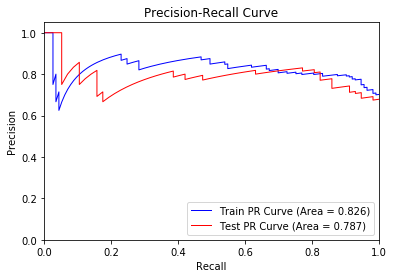

In [11]:
# Plot Train and Test PR Curves

# Train
precision, recall, thresholds = precision_recall_curve(y_train_1, y_pred_probs_train, pos_label=1)
prc_auc = auc(recall, precision)
plt.figure()
plt.plot(recall, precision, color='blue', lw=1, label='Train PR Curve (Area = %0.3f)' % prc_auc)
training_auprcs[0] = prc_auc

# Test
precision, recall, thresholds = precision_recall_curve(y_test_1, y_pred_probs_test, pos_label=1)
prc_auc = auc(recall, precision)
plt.plot(recall, precision, color='red', lw=1, label='Test PR Curve (Area = %0.3f)' % prc_auc)
generalization_auprcs[0] = prc_auc

# Plot parameters
# plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

In [12]:
# Save model coefficients
sparsity_mask = optimal_sgl.sparsity_mask_
print("Number of chosen variables: {0}".format(sparsity_mask.sum()))

betas_1 = optimal_sgl.coef_[:, 1] - optimal_sgl.coef_[:, 0]
betas_1[~sparsity_mask] = 0.0 # if not included in model, set to 0
betas_df = pd.DataFrame({
    "HIF": clusters['Unnamed: 0'],
    "Beta": betas_1, 
    "Cluster": clusters['x'],
    "Included (T/F)": sparsity_mask}
)
betas_df = betas_df[betas_df['Included (T/F)'] == True][['HIF', 'Beta', 'Cluster']]
betas_df.sort_values(by="Beta", ascending=False)

Number of chosen variables: 42


,HIF,Beta,Cluster
198,COUNT PROP [CANCER CELLS] IN [[TUMOR] OVER [ESI_0080]]_HE,0.157549,14
564,REGION PROPERTIES: TOTAL MINOR AXIS LENGTH (MM) OF STROMA_HE,0.135382,22
496,REGION PROPERTIES: NUMBER OF SIGNIFICANT REGIONS OF EPITHELIAL_HE,0.065413,14
509,REGION PROPERTIES: PERIMETER^2 / AREA OF LARGEST REGION OF ESI_0080_HE,0.065299,22
492,REGION PROPERTIES: NUMBER OF REGIONS OF ESI_0080_HE,0.055045,22
507,REGION PROPERTIES: PERIMETER^2 / AREA OF ESI_0080_HE,0.051030,22
518,REGION PROPERTIES: PERIMETER^2 / AREA OF SIGNIFICANT REGIONS OF TUMOR_HE,0.043025,22
248,COUNT PROP [[CANCER CELLS] OVER [[CANCER CELLS] SELECTED BY [FIBROBLAST_RADIUS_80]]] IN [EPITHEL...,0.025087,2
188,COUNT PROP [CANCER CELLS] IN [[EPITHELIAL] OVER [ESI_0080]]_HE,0.019832,14
514,REGION PROPERTIES: PERIMETER^2 / AREA OF SIGNIFICANT REGIONS OF EPITHELIAL_HE,0.013336,22


### Outer Loop 2

In [13]:
# Define outer loop train and test
X_train_2 = np.array(X_train_A.append(X_train_C))
y_train_2 = np.array(y_train_A.append(y_train_C))
print(X_train_2.shape, y_train_2.shape)

X_test_2 = np.array(X_train_B)
y_test_2 = np.array(y_train_B)
print(X_test_2.shape, y_test_2.shape)

(169, 607) (169,)
(85, 607) (85,)


In [18]:
# Define k-folds object
skf = StratifiedKFold(n_splits=num_inner_loops)
skf.get_n_splits(X_train_2, y_train_2)

5

In [ ]:
# K-folds: hyper-parameter tuning
num_regs = 30
regs = list(np.logspace(-6.0, -3.0, num_regs, base=e))
print(regs)

cv_aucs = [] # based on k-folds CV

for reg in regs:
    print(reg)
    k_folds_count = 1
    
    aucs = [] 
    for train_index, test_index in skf.split(X_train_2, y_train_2):
        print(k_folds_count)

        # Define train / test
        X_train, X_test = X_train_2[train_index], X_train_2[test_index]
        y_train, y_test = y_train_2[train_index], y_train_2[test_index]
        print(np.sum(y_train)/len(y_train), np.sum(y_test)/len(y_test))
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
        
        # SGL 
        sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=reg*(1/6), l1_reg=reg*(5/6), n_iter=1000, 
                                 tol=1e-6, old_regularisation=False, warm_start=True, random_state=seed)
        sgl.fit(X_train, y_train)

        # Compute AUC on test set
        y_probs_test = sgl.predict_proba(X_test)[1] # predicted probability y = 1
        fpr, tpr, thresholds = roc_curve(y_test, y_probs_test, pos_label=1)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        k_folds_count += 1
    
    print(aucs)
    cv_aucs.append(np.mean(np.array(aucs)))

[0.6346119295724039, 0.6377410468319559, 0.6393939393939394, 0.647927895556354, 0.6510210803689065, 0.6542550005988741, 0.6574889208288417, 0.6606150437178105, 0.6596179183135704, 0.6569499341238471, 0.657402084081926, 0.6565007785363516, 0.6682207449994012, 0.6691789435860583, 0.6683944184932328, 0.6805425799496947, 0.695568331536711, 0.6855491675649779, 0.6808719607138579, 0.6832435022158342, 0.6896095340759373, 0.6785842615882143, 0.6961731943945383, 0.706533716612768, 0.7261169002275721, 0.7307551802611092, 0.720301832554797, 0.7270960594083123, 0.7255509641873278, 0.7170259911366631]


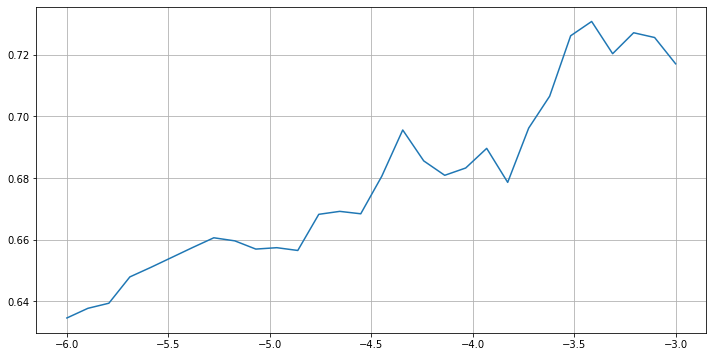

0.03291610907690537 -3.413793103448276


In [21]:
# Plot CV AUCs
print(cv_aucs)
plt.figure(figsize=(12,6))
plt.plot(np.log(regs), cv_aucs)
plt.grid(axis='both')
plt.show()

max_reg = regs[np.argmax(np.array(cv_aucs))]
print(max_reg, np.log(max_reg))

In [ ]:
# Choose best regularization parameter based on CV plot
optimal_log_reg = -3.6
optimal_reg = np.exp(optimal_log_reg)
print(optimal_log_reg, optimal_reg)

# Fit "optimal model"
optimal_sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=optimal_reg*(1/6), l1_reg=optimal_reg*(5/6), n_iter=1000, 
                         tol=1e-6, old_regularisation=False, warm_start=False, random_state=seed)
optimal_sgl.fit(X_train_2, y_train_2)

# Store optimal model
optimal_sgl_2 = optimal_sgl

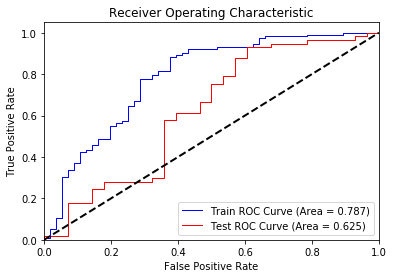

In [15]:
# Plot Train and Test ROCs
y_pred_probs_train = optimal_sgl.predict_proba(X_train_2)[1] # predicted probability y = 1
y_pred_probs_test = optimal_sgl.predict_proba(X_test_2)[1]

# Train
fpr, tpr, thresholds = roc_curve(y_train_2, y_pred_probs_train, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=1, label='Train ROC Curve (Area = %0.3f)' % roc_auc)
training_aurocs[1] = roc_auc

# Test
fpr, tpr, thresholds = roc_curve(y_test_2, y_pred_probs_test, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=1, label='Test ROC Curve (Area = %0.3f)' % roc_auc)
generalization_aurocs[1] = roc_auc

# Plot parameters
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

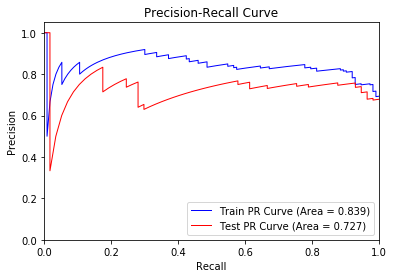

In [16]:
# Plot Train and Test PR Curves

# Train
precision, recall, thresholds = precision_recall_curve(y_train_2, y_pred_probs_train, pos_label=1)
prc_auc = auc(recall, precision)
plt.figure()
plt.plot(recall, precision, color='blue', lw=1, label='Train PR Curve (Area = %0.3f)' % prc_auc)
training_auprcs[1] = prc_auc

# Test
precision, recall, thresholds = precision_recall_curve(y_test_2, y_pred_probs_test, pos_label=1)
prc_auc = auc(recall, precision)
plt.plot(recall, precision, color='red', lw=1, label='Test PR Curve (Area = %0.3f)' % prc_auc)
generalization_auprcs[1] = prc_auc

# Plot parameters
# plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

In [17]:
# Save model coefficients
sparsity_mask = optimal_sgl.sparsity_mask_
print("Number of chosen variables: {0}".format(sparsity_mask.sum()))

betas_2 = optimal_sgl.coef_[:, 1] - optimal_sgl.coef_[:, 0]
betas_2[~sparsity_mask] = 0.0 # if not included in model, set to 0
betas_df = pd.DataFrame({
    "HIF": clusters['Unnamed: 0'],
    "Beta": betas_2, 
    "Cluster": clusters['x'],
    "Included (T/F)": sparsity_mask}
)
betas_df = betas_df[betas_df['Included (T/F)'] == True][['HIF', 'Beta', 'Cluster']]
betas_df.sort_values(by="Beta", ascending=False)

Number of chosen variables: 40


,HIF,Beta,Cluster
198,COUNT PROP [CANCER CELLS] IN [[TUMOR] OVER [ESI_0080]]_HE,0.301402,14
475,REGION PROPERTIES: LACUNARITY OF LARGEST REGION OF NECROSIS_HE,0.103649,20
248,COUNT PROP [[CANCER CELLS] OVER [[CANCER CELLS] SELECTED BY [FIBROBLAST_RADIUS_80]]] IN [EPITHEL...,0.015270,2
478,REGION PROPERTIES: LACUNARITY OF NECROSIS_HE,0.007533,4
531,REGION PROPERTIES: STANDARD DEVIATION OF EXTENTS OF SIGNIFICANT REGIONS OF EPITHELIAL_HE,0.006115,14
353,DENSITY RATIO [FIBROBLAST CELLS] IN [[TUMOR] OVER [EPITHELIAL]]_HE,0.005885,2
508,REGION PROPERTIES: PERIMETER^2 / AREA OF LARGEST REGION OF EPITHELIAL_HE,0.005730,16
193,COUNT PROP [CANCER CELLS] IN [[ESI_0080] OVER [TUMOR]]_HE,0.005538,14
456,REGION PROPERTIES: FILLED AREA (MM2) OF LARGEST REGION OF EPITHELIAL_HE,0.003649,16
78,CELL CLUSTERING PROPERTIES: CLUSTER EXTENT STANDARD DEVIATION OF LYMPHOCYTE IN STROMA_HE,0.003429,3


### Outer Loop 3

In [18]:
# Define outer loop train and test
X_train_3 = np.array(X_train_B.append(X_train_C))
y_train_3 = np.array(y_train_B.append(y_train_C))
print(X_train_3.shape, y_train_3.shape)

X_test_3 = np.array(X_train_A)
y_test_3 = np.array(y_train_A)
print(X_test_3.shape, y_test_3.shape)

(170, 607) (170,)
(84, 607) (84,)


In [27]:
# Define k-folds object
skf = StratifiedKFold(n_splits=num_inner_loops)
skf.get_n_splits(X_train_3, y_train_3)

5

In [ ]:
# K-folds: hyper-parameter tuning
num_regs = 30
regs = list(np.logspace(-6.0, -3.0, num_regs, base=e))
print(regs)

cv_aucs = [] # based on k-folds CV

for reg in regs:
    print(reg)
    k_folds_count = 1
    
    aucs = [] 
    for train_index, test_index in skf.split(X_train_3, y_train_3):
        print(k_folds_count)

        # Define train / test
        X_train, X_test = X_train_3[train_index], X_train_3[test_index]
        y_train, y_test = y_train_3[train_index], y_train_3[test_index]
        print(np.sum(y_train)/len(y_train), np.sum(y_test)/len(y_test))
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
        
        # SGL 
        sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=reg*(1/6), l1_reg=reg*(5/6), n_iter=1000, 
                                 tol=1e-6, old_regularisation=False, warm_start=True, random_state=seed)
        sgl.fit(X_train, y_train)

        # Compute AUC on test set
        y_probs_test = sgl.predict_proba(X_test)[1] # predicted probability y = 1
        fpr, tpr, thresholds = roc_curve(y_test, y_probs_test, pos_label=1)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        k_folds_count += 1
    
    print(aucs)
    cv_aucs.append(np.mean(np.array(aucs)))

[0.6338274044795784, 0.6354084321475626, 0.632312252964427, 0.6378129117259551, 0.6401844532279315, 0.6417325428194994, 0.6488471673254282, 0.6567523056653491, 0.672463768115942, 0.6810935441370225, 0.6977272727272726, 0.6894927536231883, 0.695882740447958, 0.7056324110671938, 0.7032608695652175, 0.6874176548089592, 0.6922924901185772, 0.7086627140974967, 0.6967061923583663, 0.7044137022397893, 0.7154808959156785, 0.7020750988142292, 0.711528326745718, 0.7107707509881422, 0.7084321475625824, 0.705368906455863, 0.7290184453227931, 0.7511198945981554, 0.7487483530961792, 0.7439393939393939]


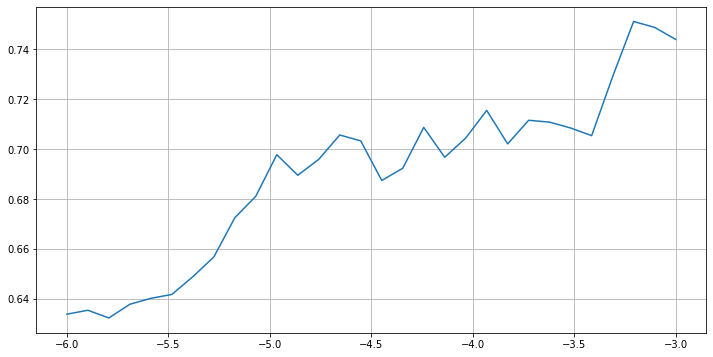

0.04048205248027766 -3.206896551724138


In [30]:
# Plot CV AUCs
print(cv_aucs)
plt.figure(figsize=(12,6))
plt.plot(np.log(regs), cv_aucs)
plt.grid(axis='both')
plt.show()

max_reg = regs[np.argmax(np.array(cv_aucs))]
print(max_reg, np.log(max_reg))

In [ ]:
# Choose best regularization parameter based on CV plot
optimal_log_reg = -3.6
optimal_reg = np.exp(optimal_log_reg)
print(optimal_log_reg, optimal_reg)

# Fit "optimal model"
optimal_sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=optimal_reg*(1/6), l1_reg=optimal_reg*(5/6), n_iter=1000, 
                         tol=1e-6, old_regularisation=False, warm_start=False, random_state=seed)
optimal_sgl.fit(X_train_3, y_train_3)

# Store optimal model
optimal_sgl_3 = optimal_sgl

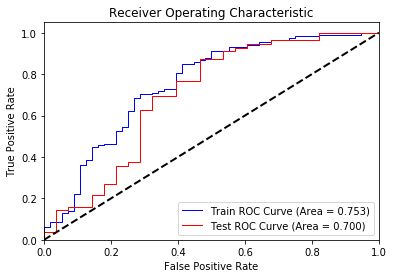

In [20]:
# Plot Train and Test ROCs
y_pred_probs_train = optimal_sgl.predict_proba(X_train_3)[1] # predicted probability y = 1
y_pred_probs_test = optimal_sgl.predict_proba(X_test_3)[1]

# Train
fpr, tpr, thresholds = roc_curve(y_train_3, y_pred_probs_train, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=1, label='Train ROC Curve (Area = %0.3f)' % roc_auc)
training_aurocs[2] = roc_auc

# Test
fpr, tpr, thresholds = roc_curve(y_test_3, y_pred_probs_test, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=1, label='Test ROC Curve (Area = %0.3f)' % roc_auc)
generalization_aurocs[2] = roc_auc

# Plot parameters
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

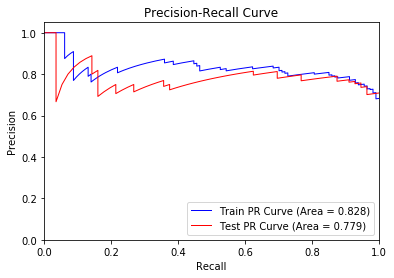

In [21]:
# Plot Train and Test PR Curves

# Train
precision, recall, thresholds = precision_recall_curve(y_train_3, y_pred_probs_train, pos_label=1)
prc_auc = auc(recall, precision)
plt.figure()
plt.plot(recall, precision, color='blue', lw=1, label='Train PR Curve (Area = %0.3f)' % prc_auc)
training_auprcs[2] = prc_auc

# Test
precision, recall, thresholds = precision_recall_curve(y_test_3, y_pred_probs_test, pos_label=1)
prc_auc = auc(recall, precision)
plt.plot(recall, precision, color='red', lw=1, label='Test PR Curve (Area = %0.3f)' % prc_auc)
generalization_auprcs[2] = prc_auc

# Plot parameters
# plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

In [22]:
# Save model coefficients
sparsity_mask = optimal_sgl.sparsity_mask_
print("Number of chosen variables: {0}".format(sparsity_mask.sum()))

betas_3 = optimal_sgl.coef_[:, 1] - optimal_sgl.coef_[:, 0]
betas_3[~sparsity_mask] = 0.0 # if not included in model, set to 0
betas_df = pd.DataFrame({
    "HIF": clusters['Unnamed: 0'],
    "Beta": betas_3, 
    "Cluster": clusters['x'],
    "Included (T/F)": sparsity_mask}
)
betas_df = betas_df[betas_df['Included (T/F)'] == True][['HIF', 'Beta', 'Cluster']]
betas_df.sort_values(by="Beta", ascending=False)

Number of chosen variables: 229


,HIF,Beta,Cluster
192,COUNT PROP [CANCER CELLS] IN [[ESI_0080] OVER [STROMA]]_HE,0.094007,13
475,REGION PROPERTIES: LACUNARITY OF LARGEST REGION OF NECROSIS_HE,0.080792,20
434,REGION PROPERTIES: AVERAGE SOLIDITY OF SIGNIFICANT REGIONS OF STROMA_HE,0.078780,16
595,TOTAL [LYMPHOCYTE CELLS] IN [EPITHELIAL]_HE,0.035461,1
315,COUNT PROP [[[CANCER CELLS] SELECTED BY [MACROPHAGE_RADIUS_80]] OVER [[CANCER CELLS] SELECTED BY...,0.030564,10
...,...,...,...
195,COUNT PROP [CANCER CELLS] IN [[STROMA] OVER [ESI_0080]]_HE,-0.059985,13
451,REGION PROPERTIES: EXTENT OF LARGEST REGION OF EPITHELIAL_HE,-0.071765,20
443,REGION PROPERTIES: ECCENTRICITY OF LARGEST REGION OF NECROSIS_HE,-0.191569,21
454,REGION PROPERTIES: EXTENT OF LARGEST REGION OF STROMA_HE,-0.403175,16


## Compute Ensemble Model

In [24]:
betas_df = pd.DataFrame({
    "HIF": clusters['Unnamed: 0'],
    "Beta_1": betas_1, 
    "Beta_2": betas_2,
    "Beta_3": betas_3,
    "Cluster": clusters['x']
    }
)
betas_df['Beta'] = (betas_df['Beta_1'] + betas_df['Beta_2'] + betas_df['Beta_3'])/3.0
betas_df.sort_values(by="Beta", ascending=False)

,HIF,Beta_1,Beta_2,Beta_3,Cluster,Beta
198,COUNT PROP [CANCER CELLS] IN [[TUMOR] OVER [ESI_0080]]_HE,0.157549,0.301402,0.023841,14,0.160931
475,REGION PROPERTIES: LACUNARITY OF LARGEST REGION OF NECROSIS_HE,0.000000,0.103649,0.080792,20,0.061480
564,REGION PROPERTIES: TOTAL MINOR AXIS LENGTH (MM) OF STROMA_HE,0.135382,0.000000,0.001857,22,0.045746
496,REGION PROPERTIES: NUMBER OF SIGNIFICANT REGIONS OF EPITHELIAL_HE,0.065413,0.000000,0.028810,14,0.031408
192,COUNT PROP [CANCER CELLS] IN [[ESI_0080] OVER [STROMA]]_HE,0.000000,0.000000,0.094007,13,0.031336
...,...,...,...,...,...,...
463,REGION PROPERTIES: FRACTAL DIMENSION OF LARGEST REGION OF EPITHELIAL_HE,0.000000,-0.184052,-0.013482,16,-0.065845
473,REGION PROPERTIES: LACUNARITY OF LARGEST REGION OF EPITHELIAL_HE,-0.035908,-0.164761,-0.017299,14,-0.072656
443,REGION PROPERTIES: ECCENTRICITY OF LARGEST REGION OF NECROSIS_HE,-0.686218,-0.001027,-0.191569,21,-0.292938
454,REGION PROPERTIES: EXTENT OF LARGEST REGION OF STROMA_HE,0.000000,-0.574813,-0.403175,16,-0.325996


## Compute Final Train / Test Metrics

In [25]:
print(training_aurocs)
print(np.mean(training_aurocs), np.std(training_aurocs))

[0.7651706700379265, 0.7868204804045513, 0.7525062656641603]
0.7681658053688794 0.014167908809476392


In [26]:
print(generalization_aurocs)
print(np.mean(generalization_aurocs), np.std(generalization_aurocs))

[0.6973684210526315, 0.62468671679198, 0.7002551020408163]
0.6741034132951427 0.0349627482877243


In [27]:
print(training_auprcs)
print(np.mean(training_auprcs), np.std(training_auprcs))

[0.8257274828125106, 0.8389605670624274, 0.8277743801037968]
0.8308208099929115 0.005816022752896681


In [28]:
print(generalization_auprcs)
print(np.mean(generalization_auprcs), np.std(generalization_auprcs))

[0.7873104336957495, 0.7268051021126025, 0.7789612215461206]
0.7643589191181576 0.026772426295785648


## Evaluate Hold-Out Set

In [29]:
holdout_df = pd.read_csv("{0}/data/genetic_data/TIGIT/datasets/stad.tigit.joined.HOLDOUT.csv".format(working_dir))
holdout_df = holdout_df.iloc[:,1:]
holdout_df

,AREA..MM2..OF..EPITHELIAL..IN..TISSUE._HE,AREA..MM2..OF..ESI_0080..IN..TISSUE._HE,AREA..MM2..OF..NECROSIS..IN..TISSUE._HE,AREA..MM2..OF..STROMA..IN..TISSUE._HE,AREA..MM2..OF..TUMOR..IN..TISSUE._HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.EPITHELIAL_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.ESI_0080_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.STROMA_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.TUMOR_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.FIBROBLAST.IN.EPITHELIAL_HE,...,DENSITY..LYMPHOCYTE.CELLS..IN..TUMOR._HE,DENSITY..MACROPHAGE.CELLS..IN..EPITHELIAL._HE,DENSITY..MACROPHAGE.CELLS..IN..ESI_0080._HE,DENSITY..MACROPHAGE.CELLS..IN..STROMA._HE,DENSITY..MACROPHAGE.CELLS..IN..TUMOR._HE,DENSITY..PLASMA.CELLS..IN..EPITHELIAL._HE,DENSITY..PLASMA.CELLS..IN..ESI_0080._HE,DENSITY..PLASMA.CELLS..IN..STROMA._HE,DENSITY..PLASMA.CELLS..IN..TUMOR._HE,joined.TIGIT_label
0,20.967920,26.908096,4.562176,9.960640,30.928560,7276.155102,7109.897710,7162.881625,7587.011393,5890.079106,...,231.824566,53.224163,107.774255,344.957754,147.177883,13.449117,117.696919,322.067658,112.840688,0
1,5.561952,15.443124,0.145216,19.614880,25.176832,5809.600670,6343.137744,6323.425989,6622.191015,4994.047755,...,2872.521849,52.319761,109.369063,191.283352,160.584143,82.884570,208.636543,328.118245,273.942329,1
2,8.840400,14.701344,0.596208,12.003328,20.843728,6607.093302,6781.979545,6280.097632,7077.515147,5948.476450,...,2848.290862,82.349215,152.230980,272.840999,192.048179,648.047600,725.375857,906.998459,797.170257,1
3,2.824304,7.961844,0.021408,13.157760,15.982064,5606.511459,5305.557452,5696.184195,6130.182737,5449.218610,...,742.394724,12.038364,27.882988,38.456394,33.787876,45.674970,133.888582,150.785544,132.210708,0
4,6.140592,14.403620,1.187904,31.627072,37.767664,6344.313408,5388.310812,6309.654817,6831.599787,5827.704610,...,2134.974512,28.173179,36.726878,219.748448,188.600492,9.445343,20.550389,21.911608,19.884735,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,105.665040,183.396776,4.844480,135.345968,241.011008,7097.986120,6935.958813,6512.172073,7193.044989,6414.969935,...,1027.343116,55.742183,69.630450,108.477557,85.357097,73.382833,135.869346,182.835147,134.848612,1
83,39.131056,63.708776,16.374176,61.549024,100.680080,5877.658131,6408.470450,5392.543322,5960.688470,4955.038907,...,777.303713,42.242663,76.425891,198.524675,137.782966,17.888605,36.164562,131.894862,87.584356,0
84,76.872160,128.647732,1.674992,96.225184,173.097344,6079.464478,6367.159464,5947.752867,6346.569587,5185.458907,...,1333.134262,33.328061,96.861404,196.050547,123.785839,47.403377,116.978355,210.485438,138.061044,0
85,74.135744,102.547360,12.267408,92.817552,166.953296,6521.817916,6462.533081,5787.717947,6698.129215,5066.682916,...,1495.639835,21.163880,74.502162,184.695670,112.079249,20.745728,97.125855,174.708335,106.341117,1


In [30]:
# Normalize HIFs and define X, y
X_holdout = holdout_df.iloc[:,:607]
X_normalized_holdout = (X_holdout-X_holdout.mean())/X_holdout.std()
X_normalized_holdout

,AREA..MM2..OF..EPITHELIAL..IN..TISSUE._HE,AREA..MM2..OF..ESI_0080..IN..TISSUE._HE,AREA..MM2..OF..NECROSIS..IN..TISSUE._HE,AREA..MM2..OF..STROMA..IN..TISSUE._HE,AREA..MM2..OF..TUMOR..IN..TISSUE._HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.EPITHELIAL_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.ESI_0080_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.STROMA_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.TUMOR_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.FIBROBLAST.IN.EPITHELIAL_HE,...,DENSITY..LYMPHOCYTE.CELLS..IN..STROMA._HE,DENSITY..LYMPHOCYTE.CELLS..IN..TUMOR._HE,DENSITY..MACROPHAGE.CELLS..IN..EPITHELIAL._HE,DENSITY..MACROPHAGE.CELLS..IN..ESI_0080._HE,DENSITY..MACROPHAGE.CELLS..IN..STROMA._HE,DENSITY..MACROPHAGE.CELLS..IN..TUMOR._HE,DENSITY..PLASMA.CELLS..IN..EPITHELIAL._HE,DENSITY..PLASMA.CELLS..IN..ESI_0080._HE,DENSITY..PLASMA.CELLS..IN..STROMA._HE,DENSITY..PLASMA.CELLS..IN..TUMOR._HE
0,-0.887706,-1.022079,-0.416578,-1.415225,-1.370466,1.238628,1.198649,2.154261,1.665051,0.994308,...,-1.421622,-1.433072,-0.104625,0.111063,1.239454,0.187016,-0.591499,-0.143424,0.313594,-0.340624
1,-1.283213,-1.270237,-0.687847,-1.172815,-1.457143,-0.801077,-0.009762,0.858177,0.138833,-0.194310,...,1.584822,2.265597,-0.120900,0.132205,-0.038671,0.342107,0.121164,0.514384,0.340707,0.804037
2,-1.199048,-1.286292,-0.660149,-1.363935,-1.522442,0.308087,0.681851,0.791280,0.859095,1.071775,...,1.842780,2.231658,0.419485,0.700407,0.639652,0.706100,5.921814,4.252199,2.934689,4.521679
3,-1.353495,-1.432168,-0.695450,-1.334948,-1.595706,-1.083537,-1.644985,-0.110258,-0.639459,0.409491,...,-1.153378,-0.717946,-0.845770,-0.948021,-1.309748,-1.124743,-0.260743,-0.026303,-0.453927,-0.202996
4,-1.268358,-1.292737,-0.623810,-0.871200,-1.267402,-0.057391,-1.514566,0.836915,0.470090,0.911566,...,0.615095,1.232558,-0.555422,-0.830782,0.198076,0.666215,-0.632592,-0.846130,-1.031416,-1.001095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,1.286665,2.365092,-0.399240,1.733086,1.795428,0.990828,0.924522,1.149593,1.041848,1.690595,...,-0.405686,-0.318836,-0.059313,-0.394593,-0.727375,-0.528162,0.023642,-0.011975,-0.310312,-0.184253
83,-0.421416,-0.225535,0.308859,-0.119887,-0.319326,-0.706422,0.093202,-0.579067,-0.907577,-0.246057,...,-0.798255,-0.669052,-0.302239,-0.304509,0.021555,0.078330,-0.545933,-0.733186,-0.538577,-0.520075
84,0.547485,1.180058,-0.593895,0.750799,0.771985,-0.425747,0.028096,0.278153,-0.297164,0.059604,...,0.162958,0.109467,-0.462659,-0.033604,0.000978,-0.083596,-0.243003,-0.148622,-0.186410,-0.161428
85,0.477235,0.615120,0.056641,0.665237,0.679396,0.189485,0.178405,0.031066,0.258957,-0.097957,...,0.499790,0.337079,-0.681555,-0.330011,-0.093462,-0.219025,-0.516609,-0.292224,-0.346728,-0.386805


In [31]:
y_holdout = holdout_df.iloc[:,607]
print(np.sum(y_holdout))

55


In [32]:
X_normalized_holdout = np.array(X_normalized_holdout)
y_pred_probs_1 = optimal_sgl_1.predict_proba(X_normalized_holdout)[1] # predicted probability y = 1
y_pred_probs_2 = optimal_sgl_2.predict_proba(X_normalized_holdout)[1]
y_pred_probs_3 = optimal_sgl_3.predict_proba(X_normalized_holdout)[1] 

In [33]:
# Ensemble (average) predictions
y_pred_probs_ensemble = np.mean(np.array([list(y_pred_probs_1), list(y_pred_probs_2), list(y_pred_probs_3)]), axis=0)
# y_pred_probs_ensemble

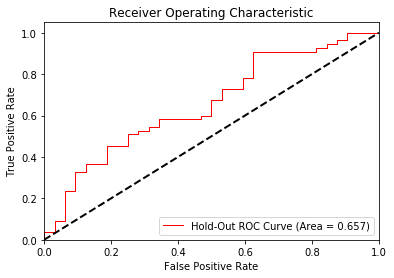

In [34]:
# Hold Out ROC
fpr, tpr, thresholds = roc_curve(y_holdout, y_pred_probs_ensemble, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=1, label='Hold-Out ROC Curve (Area = %0.3f)' % roc_auc)

# Plot parameters
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Original ROC area: 0.657


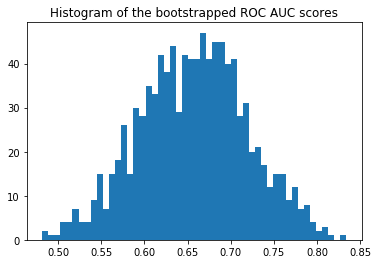

Confidence interval for the score: [0.536 - 0.779]


In [35]:
# Generate ROC 95% CI

print("Original ROC area: {:0.3f}".format(roc_auc))

n_bootstraps = 1000
bootstrapped_scores = []

rng = np.random.RandomState(seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred_probs_ensemble), len(y_pred_probs_ensemble))
    
    if len(np.unique(y_holdout[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_holdout[indices], y_pred_probs_ensemble[indices])
    bootstrapped_scores.append(score)
    # print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC AUC scores')
plt.show()

sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 94% confidence interval
confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))

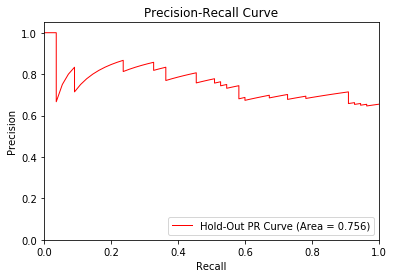

In [36]:
# Hold Out PR Curve
precision, recall, thresholds = precision_recall_curve(y_holdout, y_pred_probs_ensemble, pos_label=1)
prc_auc = auc(recall, precision)
plt.plot(recall, precision, color='red', lw=1, label='Hold-Out PR Curve (Area = %0.3f)' % prc_auc)

# Plot parameters
# plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

Original PRC area: 0.756


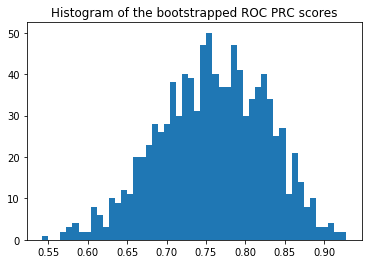

Confidence interval for the score: [0.617 - 0.882]


In [37]:
# Generate PRC 95% CI
print("Original PRC area: {:0.3f}".format(prc_auc))

n_bootstraps = 1000
bootstrapped_scores = []

rng = np.random.RandomState(seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred_probs_ensemble), len(y_pred_probs_ensemble))
    
    if len(np.unique(y_holdout[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue
    
    precision, recall, thresholds = precision_recall_curve(y_holdout[indices], y_pred_probs_ensemble[indices], pos_label=1)
    score = auc(recall, precision)
    bootstrapped_scores.append(score)
    # print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC PRC scores')
plt.show()

sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 94% confidence interval
confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))